In [1]:
from ipfml.processing.segmentation import divide_in_blocks
from ipfml.processing import transform
from ipfml.filters import convolution as conv
from ipfml.filters import kernels
from ipfml import utils
from ipfml.iqa import fr

from PIL import Image
from scipy import signal
from skimage import color
import scipy.stats as stats
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
import os
import random

In [2]:
from digital_image_processing.edge_detection.canny import canny
from digital_image_processing.filters.sobel_filter import sobel_filter
import seaborn as sns

sns.set_context("paper")
sns.set(rc={'figure.figsize':(10, 7)})

import plotly.figure_factory as ff
import plotly
from plotly.offline import iplot

In [3]:
data_folder = "../dataset"

# Edge detection analysis

## Utils functions definition

In [4]:
def compute_images_path(dict_data):
    
    scene = dict_data['name']
    prefix = dict_data['prefix']
    indices = dict_data['indices']
    
    images_path = []
    for index in indices:
        path = os.path.join(data_folder, os.path.join(scene, prefix + index + ".png"))
        print(path)
        images_path.append(path)
    return images_path

In [5]:
def get_images_zones(dict_data, images_path):
    
    id_zone = dict_data['zone']
    
    zones_img = []
    for path in images_path:
        img = Image.open(path)
        zones = divide_in_blocks(img, (200, 200))
        zones_img.append(zones[id_zone])
        
    return zones_img

In [6]:
def display_zones(dict_scene, zones, rows, columns):

    fig=plt.figure(figsize=(30, 20))
    
    indices = dict_scene['indices']
    
    for i, img in enumerate(zones):
        
        ax1 = fig.add_subplot(rows, columns, (i+1))
        ax1.title.set_text(indices[i])

        # Turn off tick labels
        ax1.set_yticklabels([])
        ax1.set_xticklabels([])
                   
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    
    plt.show()

In [7]:
def remove_pixel(img, limit):
    
    width, height = img.shape
    
    output = np.zeros((width, height))
    
    for i in range(width):
        for j in range(height):
            
            if img[i,j] <= limit:
                output[i,j] = img[i,j]
                
    return output

## Scenes information data

In [8]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00500", "00700", "00900"],
               'zone': 9}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00600", "00700","00900", "01200"],
               'zone': 6}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

### Definition of parameters

In [9]:
images_path_appart = compute_images_path(dict_appart)
images_path_cuisine = compute_images_path(dict_cuisine)

../dataset/Appart1opt02/appartAopt_00050.png
../dataset/Appart1opt02/appartAopt_00100.png
../dataset/Appart1opt02/appartAopt_00200.png
../dataset/Appart1opt02/appartAopt_00300.png
../dataset/Appart1opt02/appartAopt_00400.png
../dataset/Appart1opt02/appartAopt_00500.png
../dataset/Appart1opt02/appartAopt_00700.png
../dataset/Appart1opt02/appartAopt_00900.png
../dataset/Cuisine01/cuisine01_00050.png
../dataset/Cuisine01/cuisine01_00100.png
../dataset/Cuisine01/cuisine01_00200.png
../dataset/Cuisine01/cuisine01_00300.png
../dataset/Cuisine01/cuisine01_00400.png
../dataset/Cuisine01/cuisine01_00600.png
../dataset/Cuisine01/cuisine01_00700.png
../dataset/Cuisine01/cuisine01_00900.png
../dataset/Cuisine01/cuisine01_01200.png


In [10]:
zones_appart = get_images_zones(dict_appart, images_path_appart)
zones_cuisine = get_images_zones(dict_cuisine, images_path_cuisine)

## Study of Canny filter

In [11]:
zone = np.array(zones_appart[0])
zone_l = transform.get_LAB_L(zone)

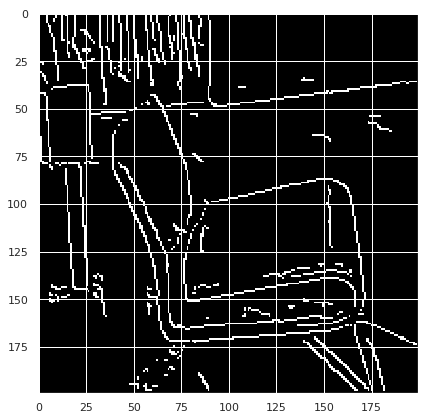

In [12]:
canny_img = canny(zone_l)
plt.imshow(canny_img,cmap='gray', vmin=0, vmax=255)

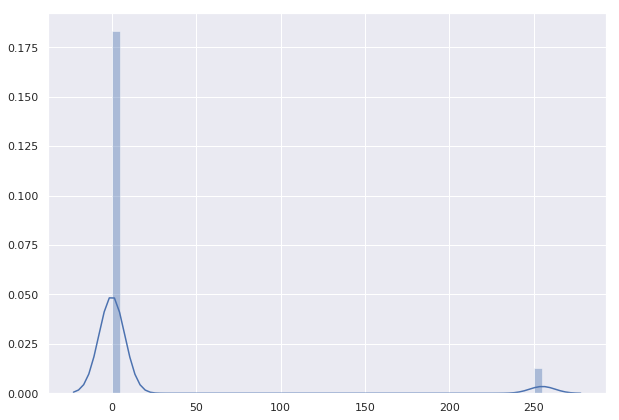

In [13]:
canny_img_dist = canny_img.reshape((40000))
sns.distplot(canny_img_dist)

## Sobel filter analysis

In [14]:
zone = np.array(zones_appart[0])
zone_l = transform.get_LAB_L(zone)

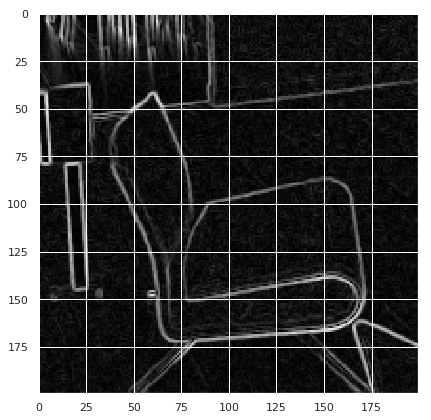

In [15]:
sobel_grad, sobel_theta = sobel_filter(zone_l)
plt.imshow(sobel_grad, cmap='gray', vmin=0, vmax=255)

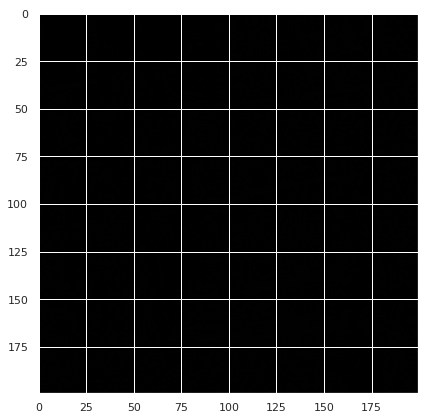

In [16]:
plt.imshow(sobel_theta, cmap='gray', vmin=0, vmax=255)

### Study of sobel distribution

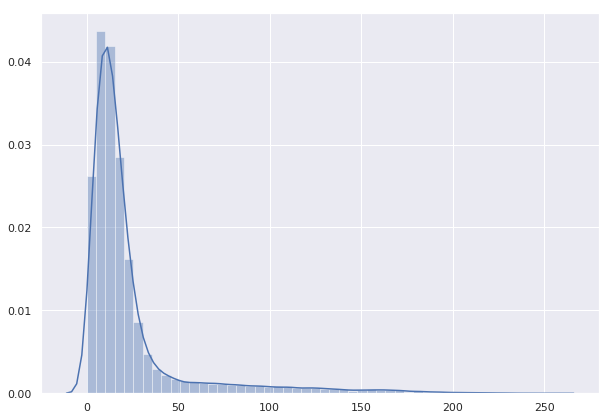

In [17]:
sobel_grad_dist = sobel_grad.reshape((40000))
sns.distplot(sobel_grad_dist)

Following this distribution we will set to 0 all pixels values which are over [30, 50, 100]

Using 50 as limit:

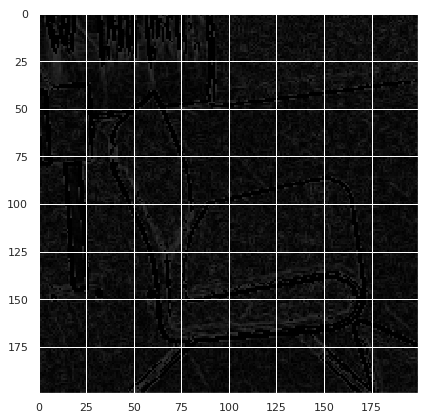

In [18]:
sobel_grad_50 = remove_pixel(sobel_grad, 50)
plt.imshow(sobel_grad_50, cmap='gray', vmin=0, vmax=255)

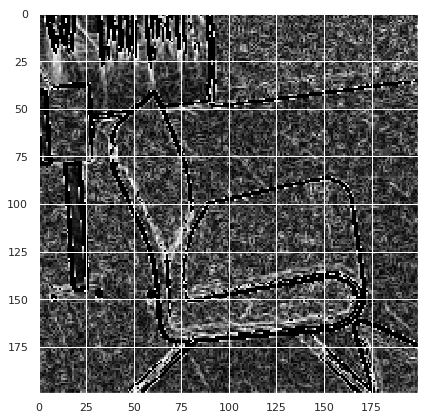

In [19]:
plt.imshow(sobel_grad_50, cmap='gray', vmin=0, vmax=50)

Using 100 as limit:

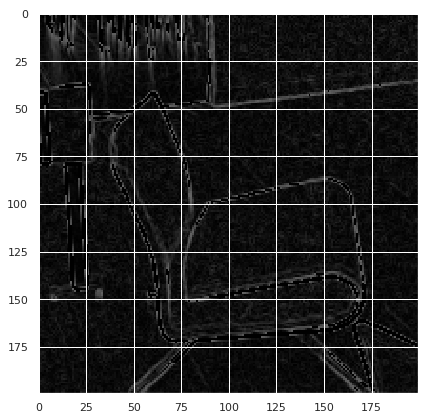

In [20]:
sobel_grad_100 = remove_pixel(sobel_grad, 100)
plt.imshow(sobel_grad_100, cmap='gray', vmin=0, vmax=255)

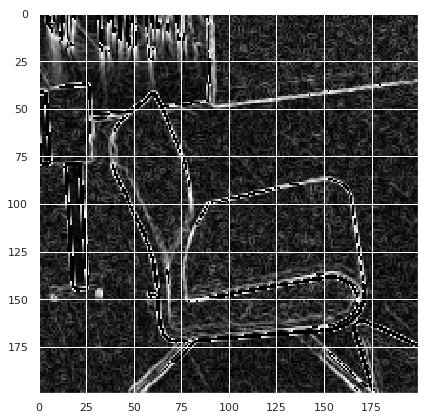

In [21]:
plt.imshow(sobel_grad_100, cmap='gray', vmin=0, vmax=100)

Using 30 as limit:

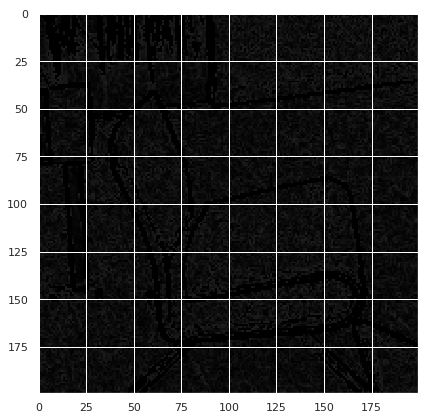

In [22]:
sobel_grad_30 = remove_pixel(sobel_grad, 30)
plt.imshow(sobel_grad_30, cmap='gray', vmin=0, vmax=255)

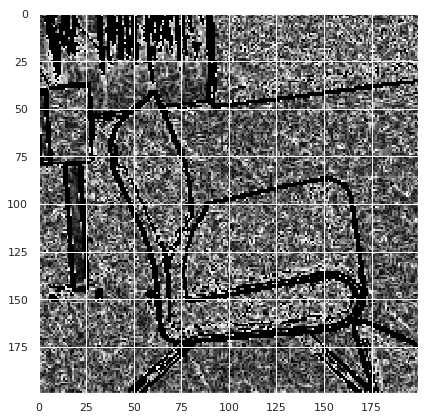

In [23]:
plt.imshow(sobel_grad_30, cmap='gray', vmin=0, vmax=30)

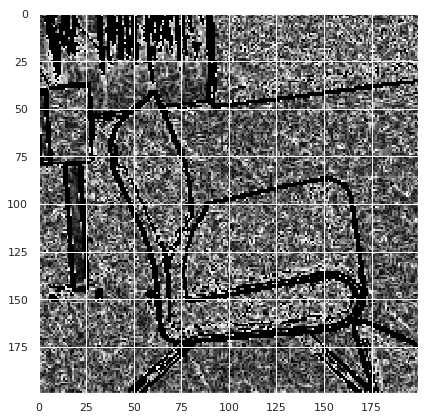

In [24]:
# try using normalization
sobel_grad_30_norm = utils.normalize_2D_arr(sobel_grad_30)
plt.imshow(sobel_grad_30_norm, cmap='gray', vmin=0, vmax=1)

### Generalization of sobel use

Apply sobel filter on different level of noise in images

In [25]:
sobel_zones = []
for zone in zones_appart:
    zone_l = transform.get_LAB_L(zone)
    sobel_grad, sobel_theta = sobel_filter(zone_l)
    sobel_grad_30 = remove_pixel(sobel_grad, 30)
    sobel_grad_30_norm = utils.normalize_2D_arr(sobel_grad_30)
    sobel_grad_30_norm = np.array(sobel_grad_30_norm*255, 'uint8')
    sobel_zones.append(sobel_grad_30_norm)

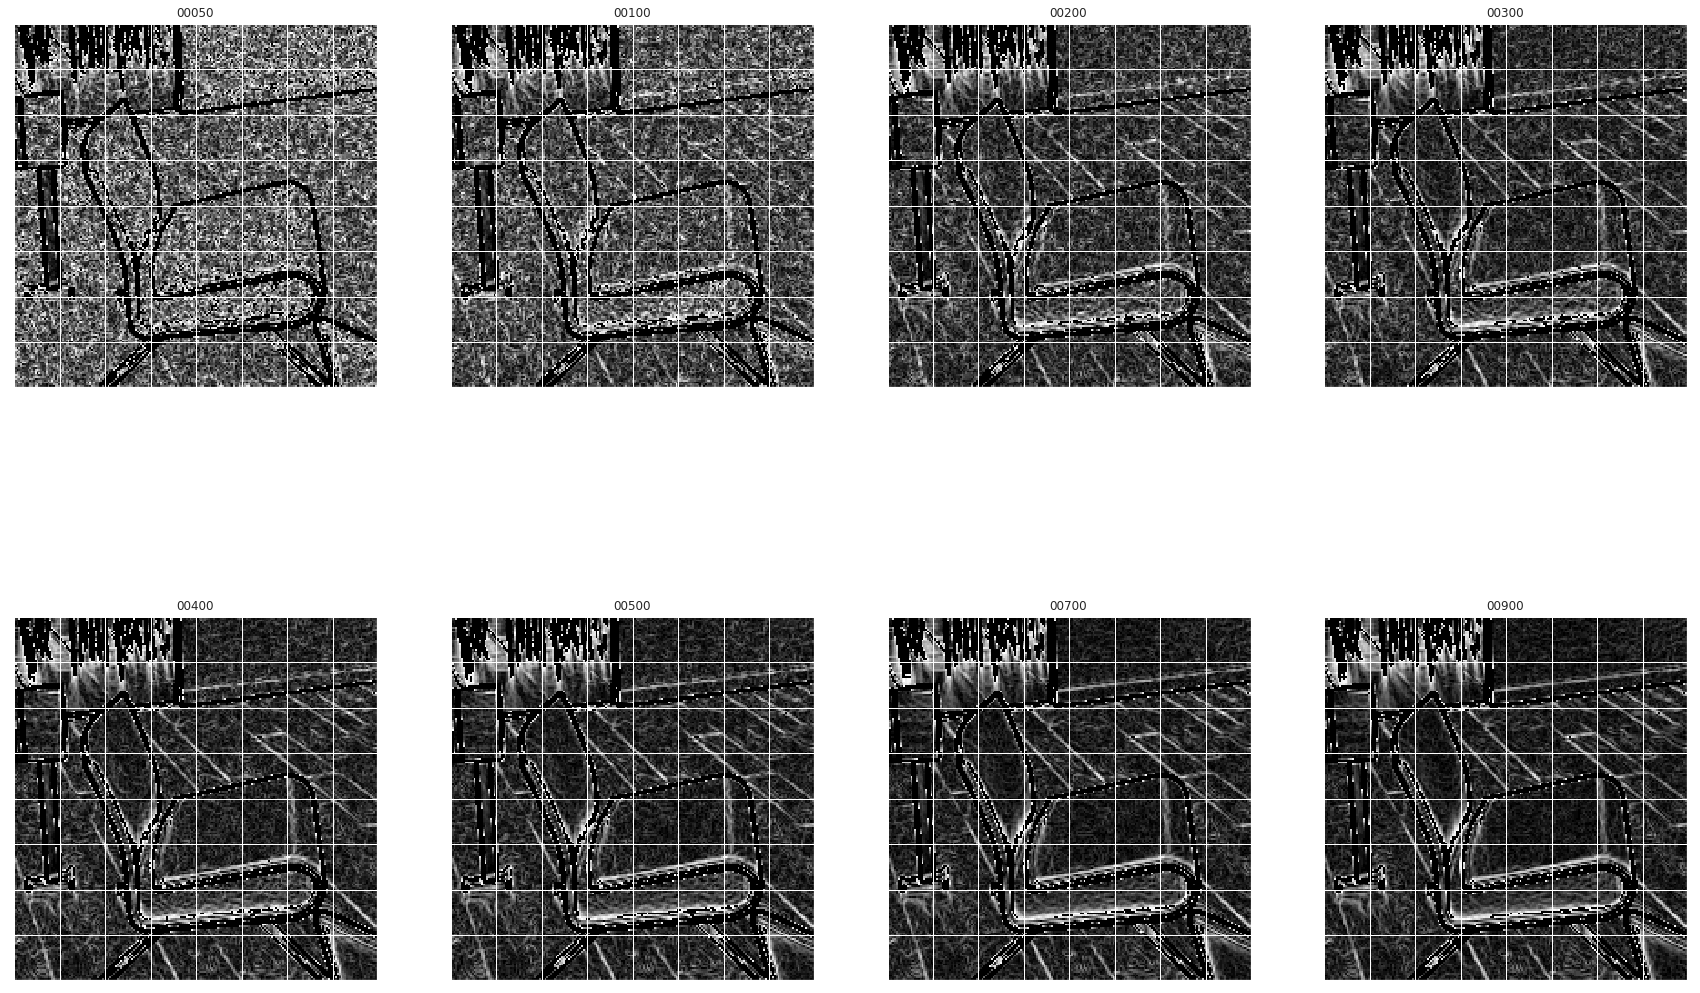

In [26]:
display_zones(dict_appart, sobel_zones, 2, 4)

It seems the filter care attention of present noise into the scene. Let's compute SSIM between most sobel filter obtained from most noisy image and others.

In [27]:
selected_sobel_zone = sobel_zones[0]
indices = dict_appart['indices']

for i, sobel_zone in enumerate(sobel_zones):
    score = fr.ssim(selected_sobel_zone, sobel_zone)
    print("Difference between (" + str(indices[0]) + ", " + str(indices[i]) + ") => " + str(score))

Difference between (00050, 00050) => 1.0
Difference between (00050, 00100) => 0.4162070608072902
Difference between (00050, 00200) => 0.2931616134838471
Difference between (00050, 00300) => 0.24738271340201531
Difference between (00050, 00400) => 0.2329356379108702
Difference between (00050, 00500) => 0.22003614321511586
Difference between (00050, 00700) => 0.20418593796824586
Difference between (00050, 00900) => 0.2009585396654271


### Study of pixel distribution of image without edges

In [28]:
zone = np.array(zones_appart[0])
zone_l = transform.get_LAB_L(zone)

In [29]:
sobel_grad, sobel_theta = sobel_filter(zone_l)
sobel_grad_30 = remove_pixel(sobel_grad, 30)

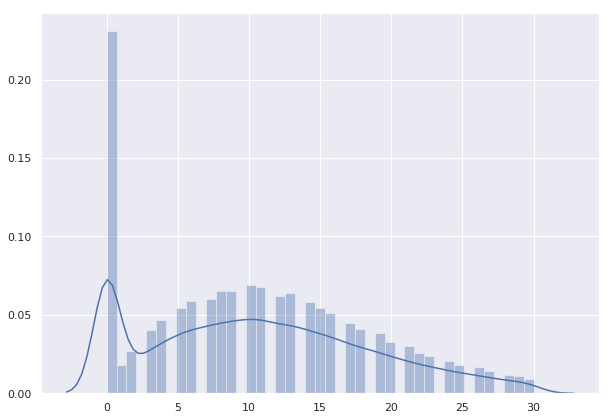

In [30]:
sobel_grad_30_dist = sobel_grad_30.reshape((200*200))
sns.set(rc={'figure.figsize':(10, 7)})
sns.distplot(sobel_grad_30_dist)

Here we see that pixel value of 0 used is mainly used because of the suppression of edge. We remove now 0 value from this distribution

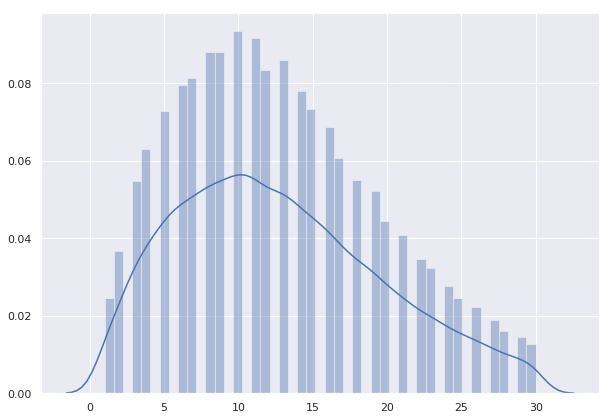

In [31]:
sobel_grad_30_dist_without_0 = [x for x in sobel_grad_30.reshape((200*200)) if x != 0]
sns.set(rc={'figure.figsize':(10, 7)})
sns.distplot(sobel_grad_30_dist_without_0)

#### Study of distribution for each level of noise

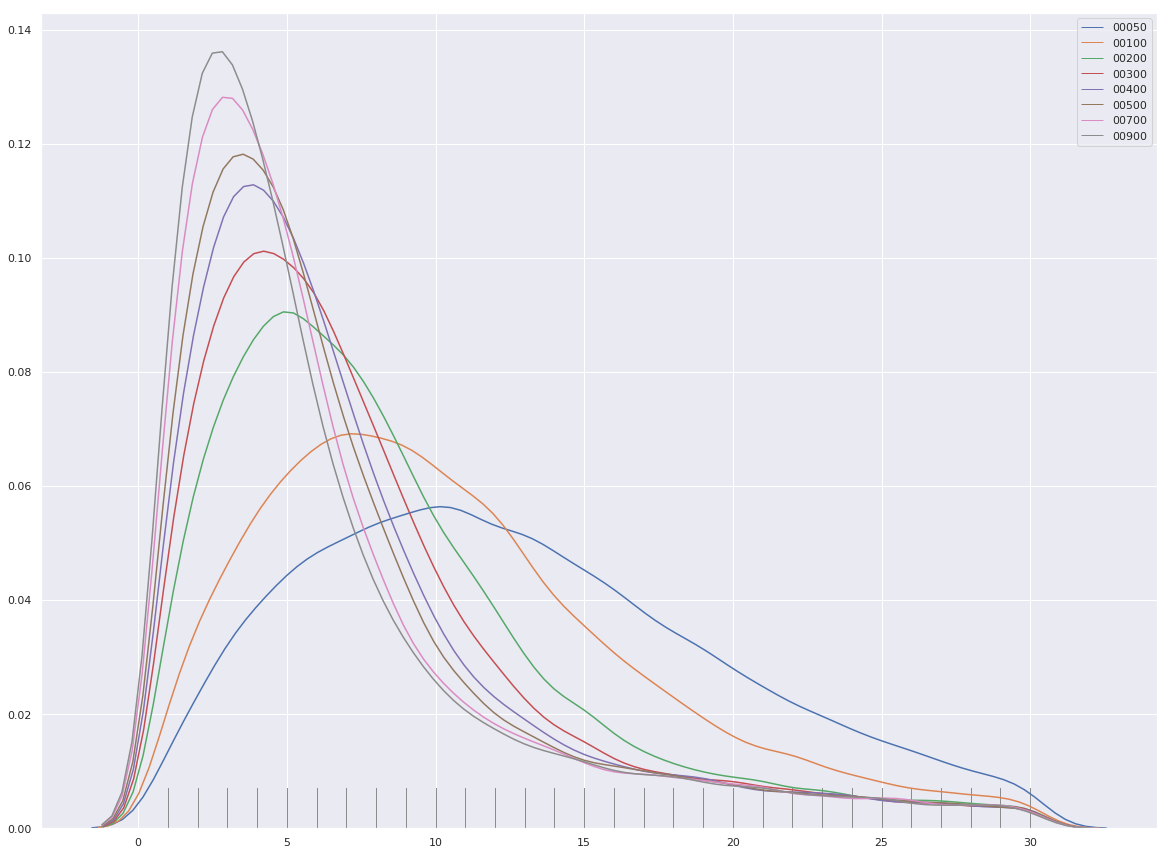

In [32]:
sns.set(rc={'figure.figsize':(20, 15)})

sobel_zones_data = []
indices = dict_appart['indices']

for zone in zones_appart:
    zone_l = transform.get_LAB_L(zone)
    sobel_grad, sobel_theta = sobel_filter(zone_l)
    sobel_grad_30 = remove_pixel(sobel_grad, 30)
    sobel_grad_30_dist_without_0 = [x for x in sobel_grad_30.reshape((200*200)) if x != 0]
    sobel_zones_data.append(sobel_grad_30_dist_without_0)
    sns.distplot(sobel_grad_30_dist_without_0, rug=True, hist=False)
    
plt.legend(labels=indices)

Distrubtion information give us information of pixels value variation. It seems for this zone that converged pixels value are in [0, 10] interval.

### Fill edge pixels using known distribution of image

In [33]:
def distribution_from_data(data):
    
    occurences = np.array([data.count(x) for x in set(data)])
    max_occurences = sum(occurences)
    
    return occurences / max_occurences

In [34]:
def get_random_value(distribution):
    rand = random.uniform(0, 1)
    prob_sum = 0.
    
    for id, prob in enumerate(distribution):
        
        prob_sum += prob
        
        if prob_sum >= rand:
            return id
        
    return len(distribution) - 1

In [35]:
zone = np.array(zones_appart[0])
zone_l = transform.get_LAB_L(zone)
sobel_grad, sobel_theta = sobel_filter(zone_l)
sobel_grad_30 = remove_pixel(sobel_grad, 30)

In [36]:
sobel_grad_30_dist_without_0 = [x for x in sobel_grad_30.reshape((200*200)) if x != 0]    

In [37]:
distribution = distribution_from_data(sobel_grad_30_dist_without_0)

#### Now we can check the new distribution function

In [38]:
min_value = int(min(sobel_grad_30_dist_without_0))

In [39]:
values = [get_random_value(distribution) + min_value for i in range(10000)]

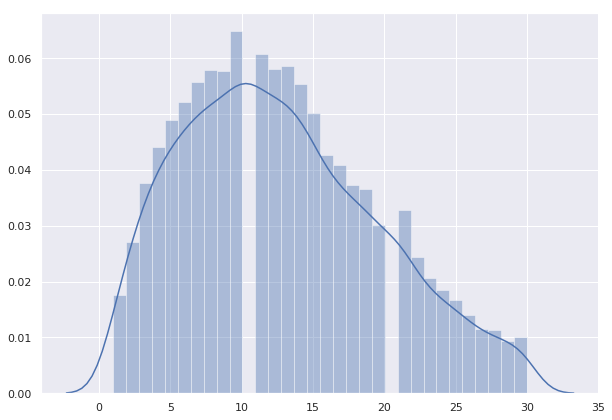

In [40]:
sns.set(rc={'figure.figsize':(10, 7)})
sns.distplot(values)

#### Fill the image 

In [41]:
def fill_image_with_rand_value(img, func, value_to_replace):
    
    width, height = img.shape
    
    output = np.zeros((width, height))
    
    for i in range(width):
        for j in range(height):
            
            if img[i,j] == value_to_replace:
                output[i, j] = func()
            else:
                output[i, j] = img[i, j]
                
    return output

In [42]:
l = lambda: get_random_value(distribution) + min_value

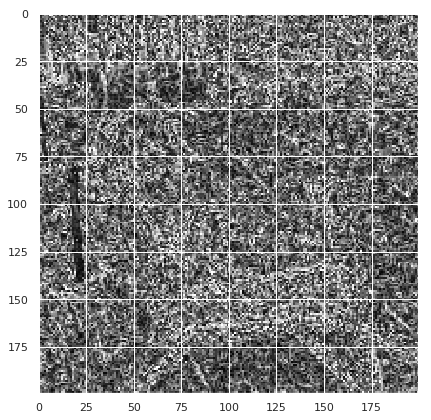

In [43]:
img_reconstructed = fill_image_with_rand_value(sobel_grad_30, l, 0)
plt.imshow(img_reconstructed, cmap='gray', vmin=0, vmax=30)

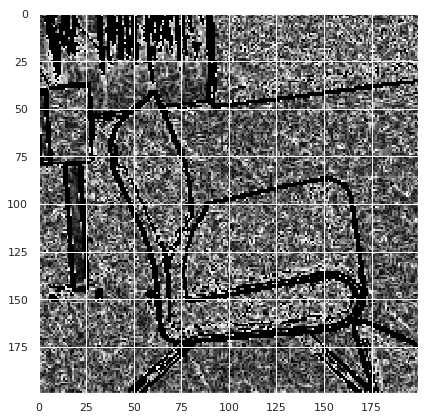

In [45]:
plt.imshow(sobel_grad_30, cmap='gray', vmin=0, vmax=30)

### Statistical analysis of each zone

In [70]:
def get_stats(dict_info, zones):
    
    indices = dict_info["indices"]
    
    for id, zone in enumerate(zones):
        std = np.std(zone)
        mean = np.mean(zone)
        
        print("For zone with " + indices[id])
        print("-- Std: ", std)
        print("-- Mean: ", mean)

Without reconstruction

In [68]:
sobel_norm_images = []

for zone in zones_appart:
    
    zone = np.array(zone)
    zone_l = transform.get_LAB_L(zone)
    sobel_grad, sobel_theta = sobel_filter(zone_l)
    sobel_grad_30 = remove_pixel(sobel_grad, 30)
    
    sobel_grad_30_norm = utils.normalize_2D_arr(sobel_grad_30)
    sobel_grad_30_norm = np.array(sobel_grad_30_norm*255, 'uint8')
    
    sobel_norm_images.append(sobel_grad_30_norm)

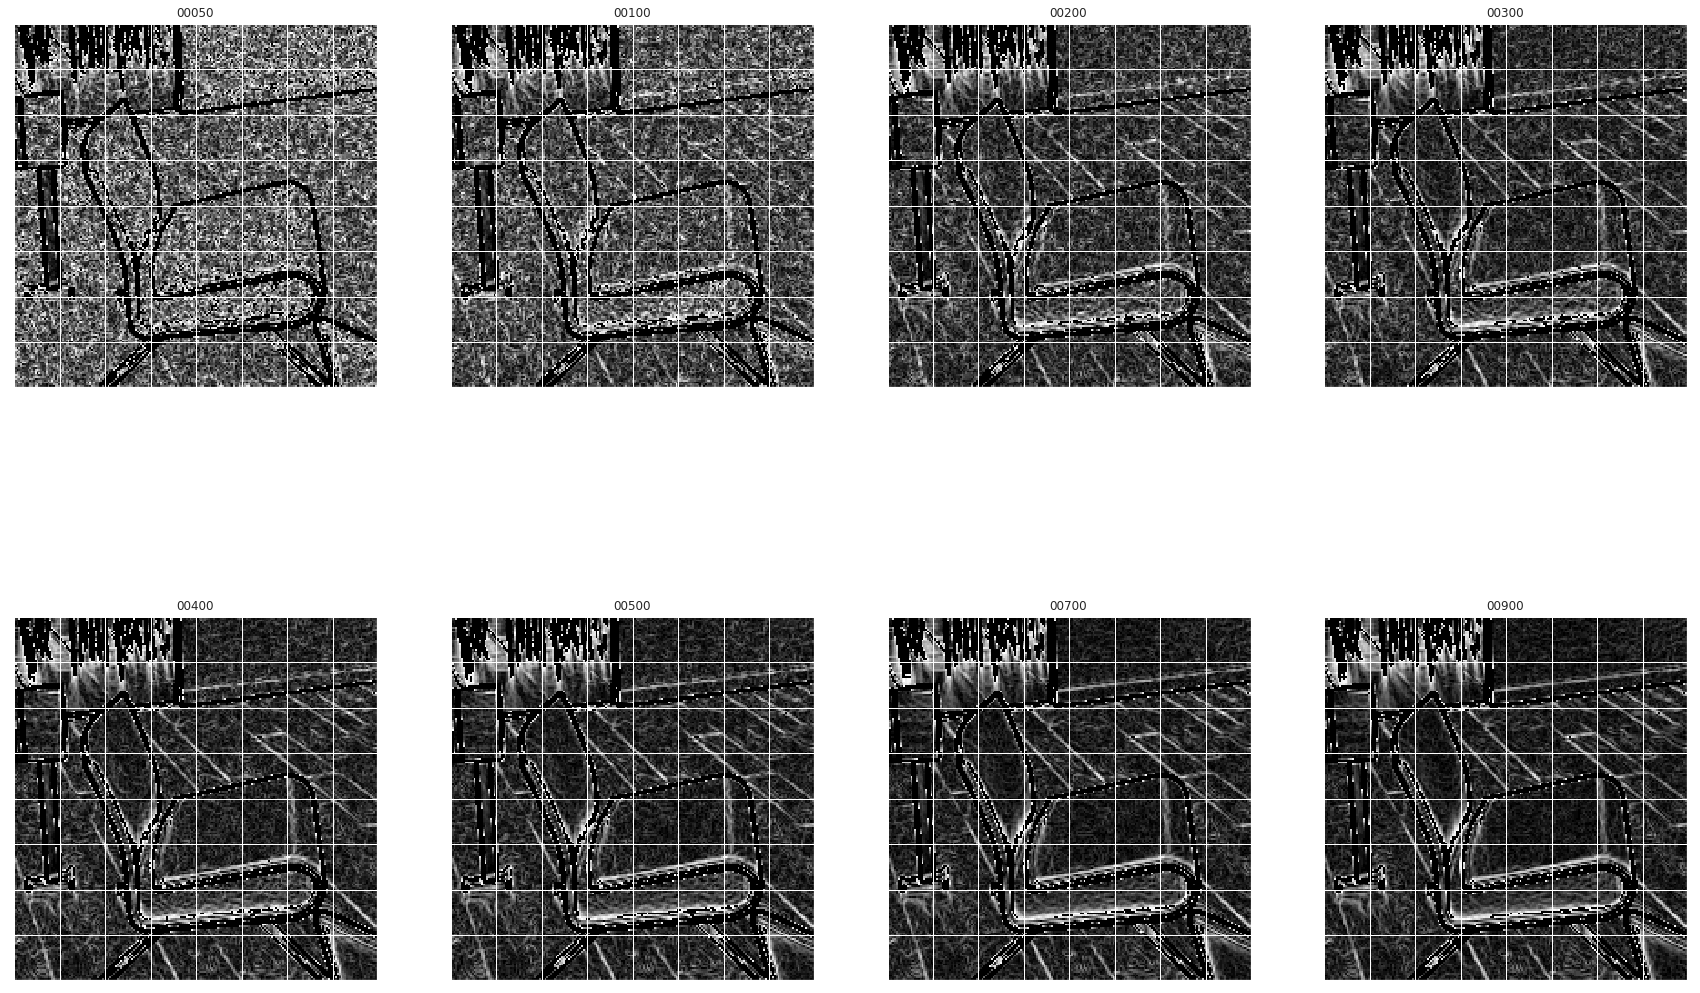

In [71]:
display_zones(dict_appart, sobel_norm_images, 2, 4)

In [72]:
get_stats(dict_appart, sobel_norm_images)

For zone with 00050
-- Std:  66.58386088865679
-- Mean:  90.6946
For zone with 00100
-- Std:  58.84156604229701
-- Mean:  76.0413
For zone with 00200
-- Std:  52.60290912751404
-- Mean:  60.56365
For zone with 00300
-- Std:  51.08855011628707
-- Mean:  54.887875
For zone with 00400
-- Std:  50.61911357382703
-- Mean:  51.479
For zone with 00500
-- Std:  50.60663240771287
-- Mean:  49.447025
For zone with 00700
-- Std:  50.550519138228196
-- Mean:  46.715325
For zone with 00900
-- Std:  50.34580462004754
-- Mean:  45.1654


Without reconstruction (fill 0 value)

In [54]:
reconstructed_images = []

for zone in zones_appart:
    
    zone = np.array(zone)
    zone_l = transform.get_LAB_L(zone)
    sobel_grad, sobel_theta = sobel_filter(zone_l)
    sobel_grad_30 = remove_pixel(sobel_grad, 30)
    sobel_grad_30_dist_without_0 = [x for x in sobel_grad_30.reshape((200*200)) if x != 0]  
    distribution = distribution_from_data(sobel_grad_30_dist_without_0)
    min_value = int(min(sobel_grad_30_dist_without_0))
    l = lambda: get_random_value(distribution) + min_value
    img_reconstructed = fill_image_with_rand_value(sobel_grad_30, l, 0)
    
    img_reconstructed_norm = utils.normalize_2D_arr(img_reconstructed)
    img_reconstructed_norm = np.array(img_reconstructed_norm*255, 'uint8')
    
    reconstructed_images.append(img_reconstructed_norm)

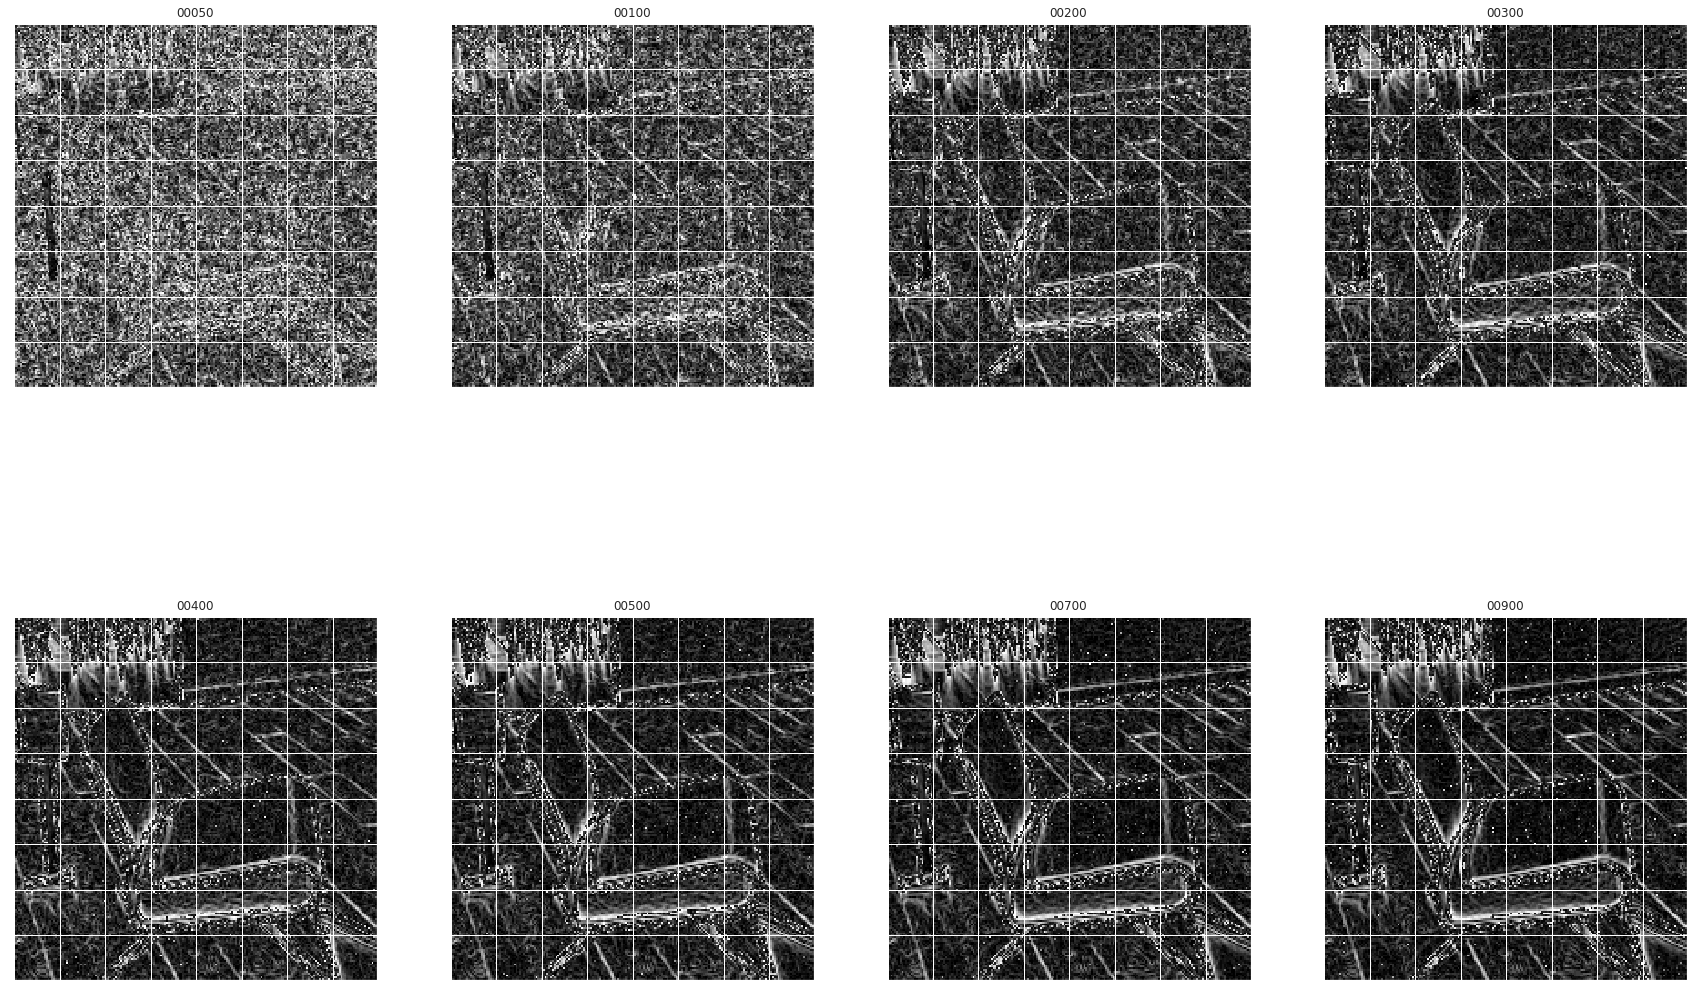

In [56]:
display_zones(dict_appart, reconstructed_images, 2, 4)

In [63]:
get_stats(dict_appart, reconstructed_images)

For zone with 00050
-- Std:  60.278798650188776
-- Mean:  102.8073
For zone with 00100
-- Std:  55.18360141359365
-- Mean:  83.795525
For zone with 00200
-- Std:  51.658876516020946
-- Mean:  65.25145
For zone with 00300
-- Std:  50.931738491576894
-- Mean:  58.379525
For zone with 00400
-- Std:  51.259395790424364
-- Mean:  54.644025
For zone with 00500
-- Std:  51.511680645242976
-- Mean:  52.13895
For zone with 00700
-- Std:  52.20217150595845
-- Mean:  49.43225
For zone with 00900
-- Std:  52.39858537317587
-- Mean:  47.7783
